In [1]:
from model import *
from data import *
from metrics import *

# 使用细胞膜数据来做语义分割吧！
任务描述：将细胞膜和细胞核按边缘进行分割

这些数据可以在 "./data/membrane"找到, 这会是一个语义分割问题!
我们的输入图片和其对应的标签有着相同的输入shape: (batch_size,256,256,channel)

![Unet-Model](img/u-net-architecture.png)

## 1.数据预处理

### 在这一部分我们将会：

①. 观察一下我们的数据！
②. 对我们的数据进行一些有趣的预处理！
③. 利用数据增强来扩增我们的数据！
④. 利用keras的生成器来打包我们的数据预处理以及数据增强！

### ① 观察数据

In [2]:
#导入必要的库
import cv2 #强大的图像操作opencv库
import numpy as np #强大的矩阵操作库numpy
from pylab import * #绘图工具pylab！
#显示中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#读取图片及标签
img=cv2.imread('./data/membrane/train/image/0.png')
label=cv2.imread('./data/membrane/train/label/0.png')
#看一下图片的大小和形状吧！
print(img.shape,label.shape)
#将两张图片拼接在一起
imgshow=np.hstack((img,label))

#绘制我们的图片
fig = plt.figure(figsize=(10,10))
subplot(111)
imshow(imgshow)
title('train_data-label')
plt.show()

(512, 512, 3) (512, 512, 3)


<Figure size 1000x1000 with 1 Axes>

### ② 预处理数据
如之前所见，我们的图片大小与模型的输入有一些不一致！另外对于输入图片，往往需要进行相应的归一化！因此，我们需要对我们的图片进行一定的预处理。

(256, 256, 3)


/home/iniesa/workspace/venv/tensorflow_2.0.0/lib/python3.5/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


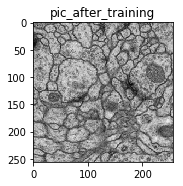

In [3]:
#复制一份我们的图片
new_img=img.copy()/255
#将新的图片进行resize 到 256，256
new_img=cv2.resize(new_img,(256,256))
print(new_img.shape)
#显示我们的图片
fig = plt.figure(figsize=(2.5,5))
subplot(111)
imshow(new_img)
title('pic_after_training')
plt.show()

### ③ 图像增强
我们可以看到，在我们的数据中只有30张的训练图片及其标签，这对于一个网络来说数据量偏少，为了加强我们网络的分割能力，我们可以使用图像增强的方法，获得更多的数据，并且让网络充分学习到图像中的不变性。

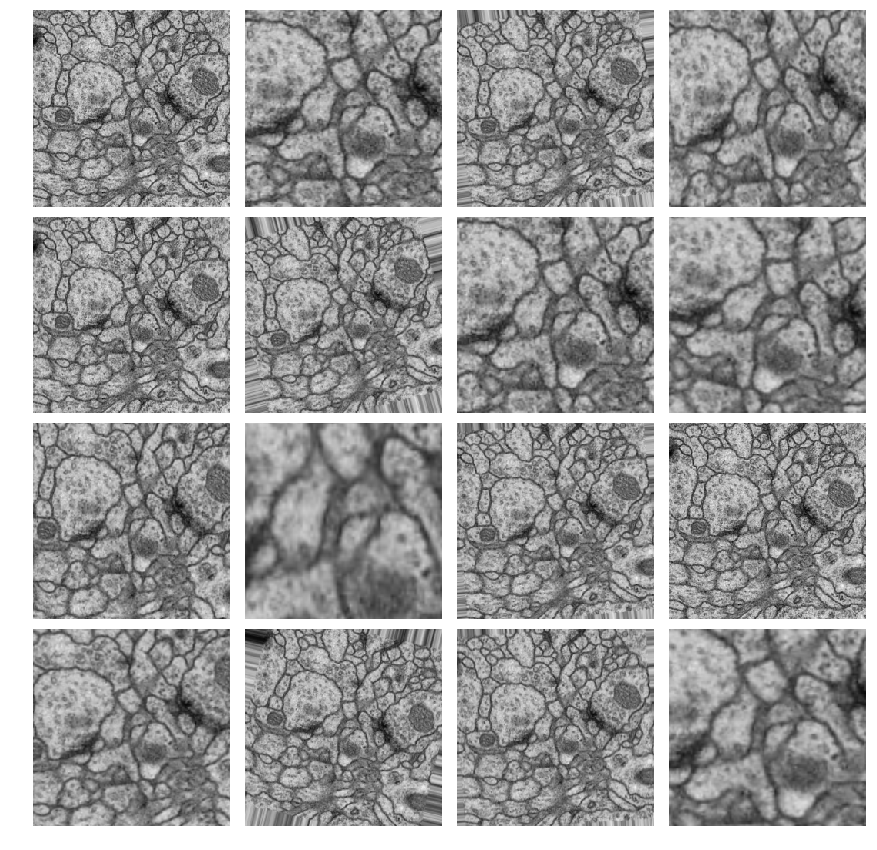

In [4]:
#引入keras中的图像增强方法，包括旋转、偏移、缩放
from tensorflow.keras.preprocessing.image import random_rotation, random_shear, random_zoom 
import random

#定义一个图像增强的函数
def augmentation_pipeline(img_arr):
    #顺次对传入的原始图片进行随机角度调整、x/y轴偏移、缩放 
    # note: operation(a) if experess else a 语句表示满足条件执行experation(a) 否则返回原图
    #我们调用randomint(0,9) 函数，生成一个0-9之间的伪随机数，当这个数小于5时，图像增强操作就会被执行，另外，我们给了缩放的比例传入了随机参数
    #也就是说，通过这一函数，我们最多可以生成 2*2*2*9*9 = 648 种 不同的增强数据！
    img_arr = random_rotation(img_arr, 18, row_axis=0, col_axis=1, channel_axis=2) if random.randint(0, 9) <5 else img_arr
    img_arr = random_shear(img_arr, intensity=0.4, row_axis=0, col_axis=1, channel_axis=2) if random.randint(0, 9) <5 else img_arr
    img_arr = random_zoom(img_arr,(random.randint(0, 9)/10,random.randint(0, 9)/10),row_axis=0,col_axis=1,channel_axis=2) if random.randint(0, 9) <5 else img_arr
    return img_arr

#将所有生成的增强图片显示在一个plt fig上
def show_sixteen(images,titles=None):
    #定义一个包含4*4 16个子图的plt fig，子图之间的间隔为0.05
    f, axarr = plt.subplots(4, 4, figsize=(15, 15), gridspec_kw={"wspace": 0.05, "hspace": 0.05})
    #遍历所有子图，每个子图有着编号和坐标轴这两个属性
    for idx, ax in enumerate(f.axes):
        #在每个子图上绘制一张增强图片
        ax.imshow(images[idx])
        ax.axis("off")
        if titles: ax.set_title(titles[idx])
    #显示我们最终的fig
    plt.show()

#定义一个list存放所有的图片
aug_imgs=[]
#第一张图片放我们的原图
aug_imgs.append(new_img)
#生成15张数据增强后的图片
aug_imgs.extend([augmentation_pipeline(new_img) for _ in range(15)])
#显示所有的图片，注意左上角第一张就是我们的原图
show_sixteen(aug_imgs)

### ④ 通过调用keras库，包装一个keras生成器
你可能觉得自己实现图像增强和数据预处理实在是太繁琐了，没问题！归功于Keras社群的活力，Keras库中已经包含了集成图片预处理，图像增强的生成器！下面让我来试着调用一个keras生成器，并加入一些自定义的功能！

In [5]:
#引入Keras的图片生成器
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#再确认一下图片是否归一化了，并把标签中的像素值one-hot化
def adjustData(img,mask):
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)


#定义我们的生成器参数，它会包括 要生成的样本数 batch_size ,训练数据的路径 train_path，图片存放的路径 image_folder 标签存放的路径 mask_folder
#图像增强的参数 aug_dict （之后会详细解释） 图片的颜色模式 image_color_mode （默认灰度图） 标签的颜色模式 mask_color_mode （默认灰度图）
#  image_save_prefix  = "image",mask_save_prefix  = "mask"  save_to_dir = None 是保存增强后图片位置，及其对应的标签前缀和图片前缀
# target_size 可以指定将图片resize到对应大小 seed 随机种子，用于保证图片和标签应用的图像增强一致。

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    同时生成图片和标签，通过设定同一随机种子，使得两个生成器对图片和标签进行相同的数据增强操作，防止增强后的数据与标签不一致
    如果你很好奇最后生成的图片是什么样子的，你可以将 save_to_dir 参数 赋予一个路径 例如：save_to_dir = './genImg'
    '''
    #定义图片、标签生成器，并传入图像增强参数
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    #引用生成器中的flow 方法，从一个指定的路径生成相应的图片，其余参数与包装函数的一致。
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    #将两个生成器生成的图片和标签整合在一起
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        #对生成的图片和标签再做一些预处理
        img,mask = adjustData(img,mask)
        yield (img,mask)

## 小结:
至此，我们成功定义了一个包含预处理和数据增强的生成器函数，下面我们将定义和训练我们的模型，当然你可能会有一些疑问，希望下面的一些小实验能解答你的疑问。

# 2. 模型定义与训练

对于这次的目标分割任务，我们使用的网络是一个Unet网络，正如其名，Unet有着如下形状的网络结构

![Unet-Model](img/u-net-architecture.png)

可以看到，Unet网络结构相对还是比较复杂的，如果你对模型的定义比较感兴趣的话，可以前往根目录中的model.py进行更进一步的阅读
时间关系，我们已经预先定义好了一个Unet网络，来尝试一下调用它吧！

### ① 模型定义

In [6]:
#调用unet网络
# model = Unet(pretrained_weights = None,input_size = (256,256,1),optimizer='Adam',lr=1e-4)
#我们提供了三个可以调节的Unet参数，包括：input_size、optimizer 和 lr 
#输入大小 input_size 可以通过调整 图片的高、宽 H,W ，注意，如果你在这里改变了输入大小，请一并在生成器传入的target size参数中进行修改！
#优化器 optimizer 我们提供了 Adam、RMSprop、Adagrad进行优化器的调节，如果不进行指定，则会调用SGD优化器。
#学习率 lr 控制网络的收敛速度，不同大小的学习率能达到的最优点往往不同，可以多多调节看看结果的异同
#调用keras的summary方法将模型的细节进行展示
# model.summary()

### 可以看到，我们的输入是256x256x1 的灰度图，输出也是256x256x1的语义分割图，Unet为对称的结构，小特征图到大特征的映射用到了上采样。

### 接下来我们使用之前写好的生成器进行训练！

### ② 生成器训练

In [7]:
#首先定义我们的生成器参数，这些参数会传给生成器中的一些图像增强的方法，来学习数据中的不变性！
#rotation_range -> 随机旋转角度
#width_shift_range -> width方向平移
#height_shift_range -> height方向平移
#shear_range -> 向width 或 height 方向倾倒
#zoom_range -> 缩放率
#horizontal_flip -> 水平翻转
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,    
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

#读取我们的数据、并定义我们的Unet模型
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = Unet()
model.summary()
#定义一些callback
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model_tensorboard=TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
model_history=History()
#返回训练过程中的logging
his=model.fit_generator(myGene,steps_per_epoch=200,epochs=10,callbacks=[model_checkpoint,model_history,model_tensorboard])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

199/200 [============================>.] - ETA: 0s - loss: 0.3485 - accuracy: 0.8452
Epoch 00001: loss improved from inf to 0.34837, saving model to unet_membrane.hdf5
200/200 [==============================] - 23s 114ms/step - loss: 0.3484 - accuracy: 0.8453
Epoch 2/10
199/200 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8869
Epoch 00002: loss improved from 0.34837 to 0.29435, saving model to unet_membrane.hdf5
200/200 [==============================] - 19s 95ms/step - loss: 0.2944 - accuracy: 0.8869
Epoch 3/10
199/200 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.9049
Epoch 00003: loss improved from 0.29435 to 0.26687, saving model to unet_membrane.hdf5
200/200 [==============================] - 19s 96ms/step - loss: 0.2669 - accuracy: 0.9049
Epoch 4/10
199/200 [============================>.] - ETA: 0s - loss: 0.2512 - accuracy: 0.9131
Epoch 00004: loss improved from 0.26687 to 0.25119, saving model to unet_membrane.hdf5
200/200 [

### ③ 训练过程可视化

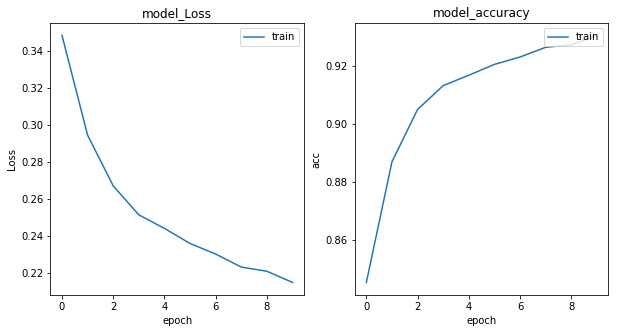

In [10]:
fig = plt.figure(figsize=(10,5))
#在子图1上可视化loss曲线
subplot(121)
plt.plot(his.history['loss'])
plt.title('model_Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train'], loc='upper right')
#在子图2上可视化准确率曲线
subplot(122)
plt.plot(his.history['accuracy'])
plt.title('model_accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train'], loc='upper right')
plt.show()

# 3. 模型评价
当我们训练完了一个模型，我们需要对其进行评价，根据结果的好坏来决定如何调优我们的模型，因此在这一部分我们会评价我们的模型以指导后续的调优。

### ① 在验证集上测试我们的模型！

In [12]:
testGene = testGenerator("data/membrane/valid/image")
model = Unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,5,verbose=1)
predict_imgs=saveResult("data/membrane/valid/pred_valid",results)

5/5 [==============================] - 0s 26ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


### 观察一下我们的预测结果！

(512, 512, 3) (512, 512, 3) (256, 256, 3)
(512, 512, 3) (512, 512, 3) (512, 512, 3)


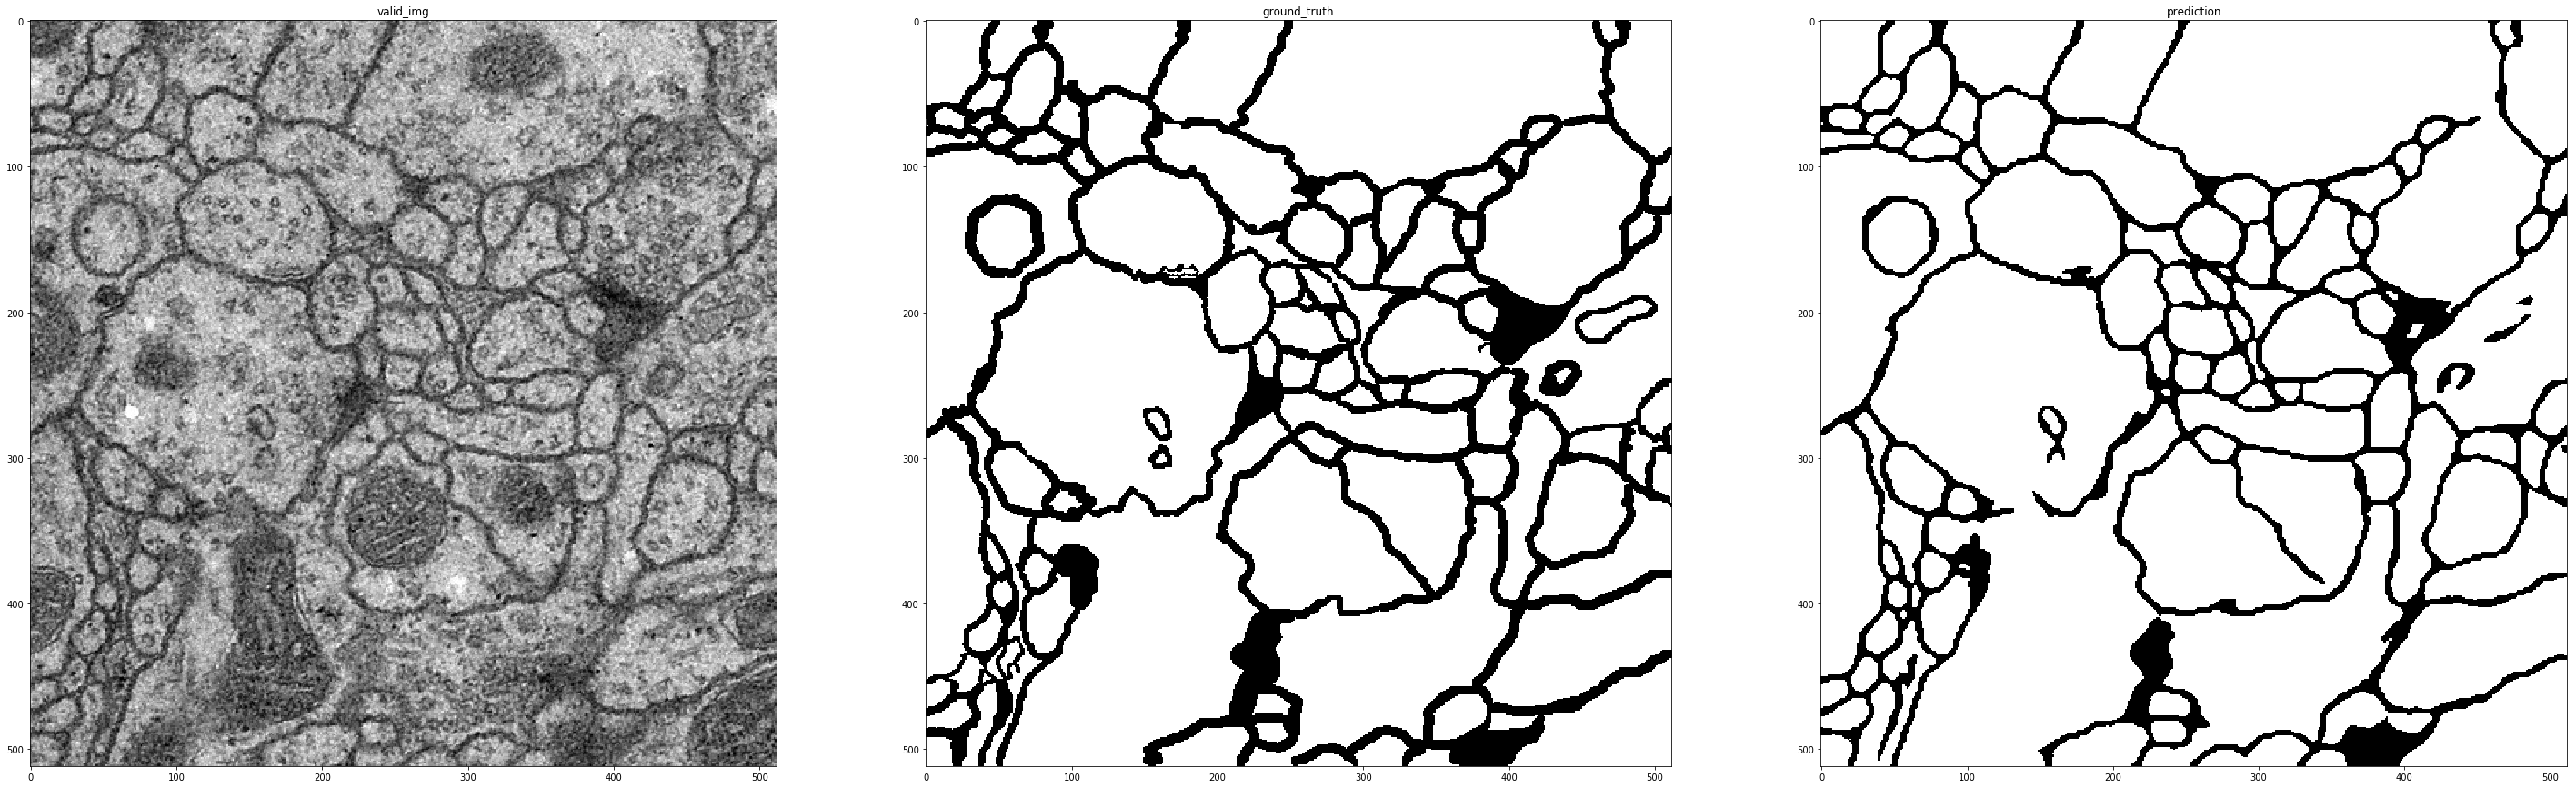

In [14]:
import cv2
import numpy as np
from pylab import *
# #显示中文
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
#读取测试集中的图片0,标签及预测结果，将其像素值都作归一化
img=cv2.imread('./data/membrane/valid/image/0.png')/255
img_gt=cv2.imread('./data/membrane/valid/label/0.png')/255
predict_img=cv2.imread('./data/membrane/valid/pred_valid/0_predict.png')/255
#预处理一下预测图像 Unet 输出 256*256 ->(resize) 512*512*3，并且将像素值映射为和标签一样的 0,1 one-hot
print(img.shape,img_gt.shape,predict_img.shape)
predict_img=cv2.resize(predict_img,(512,512),0,0)
predict_img[predict_img > 0.5] = 1
predict_img[predict_img <= 0.5] = 0
#绘制我们的测试数据0.png和相应的Unet分割结果
print(img.shape,img_gt.shape,predict_img.shape)
fig = plt.figure(figsize=(50,150))
subplot(131)
imshow(img)
title('valid_img')
subplot(132)
imshow(img_gt)
title('ground_truth')
subplot(133)
imshow(predict_img)
title('prediction')
plt.show()

### ② 计算评价指标

在目标分割中，比较常见的两个评价指标是MIoU和MPA
![Metrics](img/metrics.PNG)

In [15]:
#对图像进行阈值分割
def threshold_demo(a):
    gray = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)  # 把输入图像灰度化
    # 直接阈值化是对输入的单通道矩阵逐像素进行阈值分割。
    ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
    return binary
N_MPA=0
N_MIOU=0
#在五张验证集上测试我们的模型
for i in range(5):
    img_gt=threshold_demo(cv2.imread('./data/membrane/valid/label/0.png'))
    predict_img=cv2.imread('./data/membrane/valid/pred_valid/0_predict.png')
    predict_img=threshold_demo(cv2.resize(predict_img,(512,512)))
    N_MPA+=mean_accuracy(predict_img,img_gt)
    N_MIOU+=mean_IU(predict_img,img_gt)
print("prediction_MPA= {0:.2f}  | prediction_MIOU= {1:.2f}".format(N_MPA/5*100,N_MIOU/5*100))

prediction_MPA= 89.47  | prediction_MIOU= 66.53


### 小结：
可以看到，最终的MPA/MIOU达到了 ~90% / ~67%
我们可以以这个结果为baseline，进一步调整网络的模型结构和参数，提高这两个指标的值。

### ③ 在测试集上评估我们模型的泛化性能！
最后，我们实验一下模型的泛化性能，在test文件夹内，这些数据是没有标签的另一种植物的细胞壁图像，看看模型是否依旧能达到较好的分割效果。

In [17]:
testGene = testGenerator("data/membrane/test")
model = Unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
predict_imgs=saveResult("data/membrane/test/pred",results)

30/30 [==============================] - 1s 25ms/step


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

(512, 512, 3) (512, 512, 3)


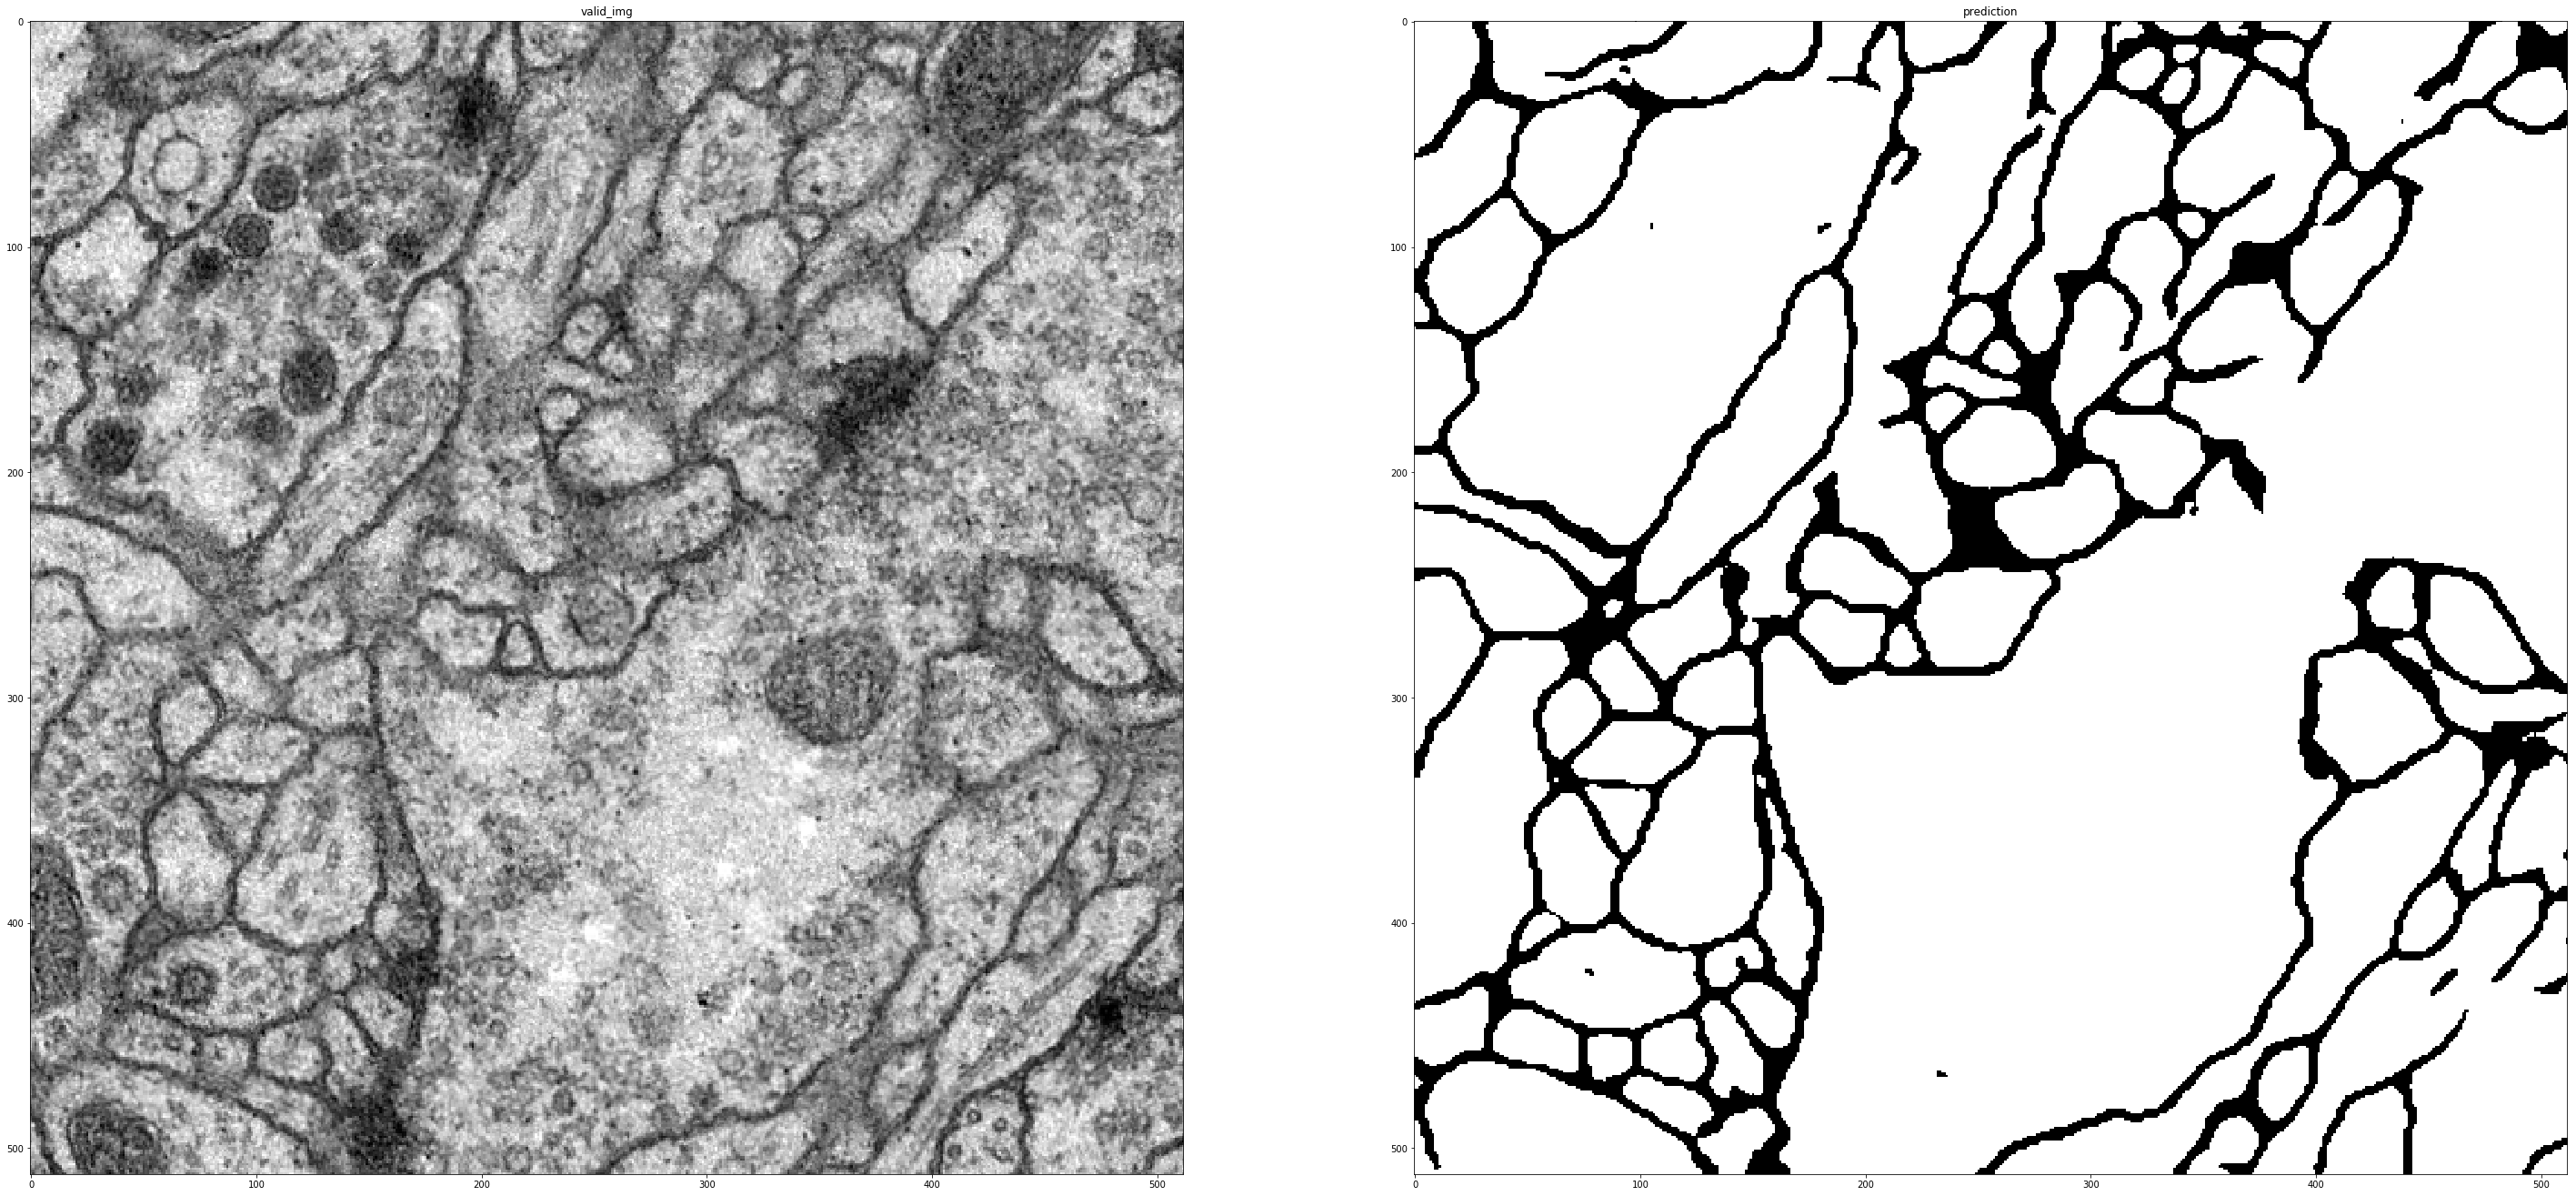

In [18]:
import cv2
import numpy as np
from pylab import *
#显示中文
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
#读取测试集中的图片0,标签及预测结果，将其像素值都作归一化
img=cv2.imread('./data/membrane/test/0.png')/255
img_pred=cv2.imread('./data/membrane/test/pred/0_predict.png')/255
#预处理一下预测图像 Unet 输出 256*256 ->(resize) 512*512*3，并且将像素值映射为和标签一样的 0,1 one-hot
img_pred=cv2.resize(img_pred,(512,512),0,0)
print(img.shape,img_pred.shape)
img_pred[img_pred > 0.5] = 1
img_pred[img_pred <= 0.5] = 0
#绘制我们的测试数据0.png和相应的Unet分割结果
# print(img.shape,img_gt.shape,predict_img.shape)
fig = plt.figure(figsize=(50,150))
subplot(121)
imshow(img)
title('valid_img')
subplot(122)
imshow(img_pred)
title('prediction')
plt.show()

# 总结：
### 至此，我们完成了全部的目标分割的实验
### 对于其他的深度学习，它总是由 数据预处理、模型定义与训练、模型评价组成的，学会了这个流程十分有意义。